In [1]:
# Import required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

# Load datasets
energy_design_a = pd.read_csv("energy_design_a.csv")
energy_design_b = pd.read_csv("energy_design_b.csv")

In [ ]:
# Start coding here (use as many cells as you need)
energy_design_a.head()

,Fuel_Source,Building_Type,Energy_Usage
0,Natural_Gas,Residential,576.997736
1,Biofuel,Commercial,626.838952
2,Natural_Gas,Commercial,542.448624
3,Natural_Gas,Residential,594.053558
4,Natural_Gas,Commercial,413.235891


In [56]:
energy_design_b.head()

,Geographical_Region,Fuel_Source,CO2_Emissions
0,North,Natural_Gas,11.490142
1,North,Natural_Gas,9.585207
2,North,Natural_Gas,11.943066
3,North,Natural_Gas,14.569090
4,North,Natural_Gas,9.297540


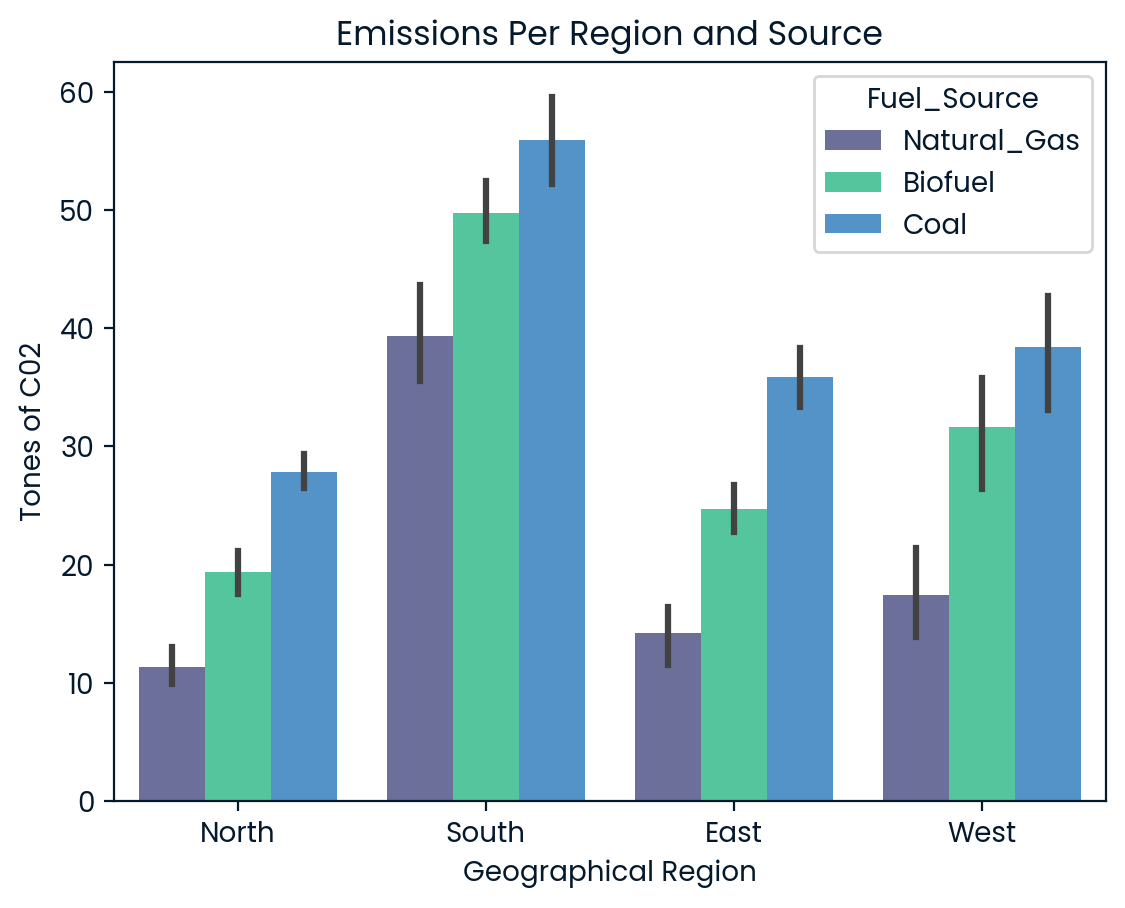

In [58]:
#Visuals
sns.barplot(data=energy_design_b, x='Geographical_Region', y='CO2_Emissions', hue='Fuel_Source')
plt.title('Emissions Per Region and Source')
plt.ylabel('Tones of C02')
plt.xlabel('Geographical Region')
plt.show()

In [2]:
#Finding maximums
grouped_data = energy_design_b.groupby(['Geographical_Region','Fuel_Source'])
highest_co2_region = grouped_data.median().idxmax()[0][0]
highest_co2_source = grouped_data.median().idxmax()[0][1]

In [3]:
#One Way ANOVA f_oneway
grouped_data = energy_design_b.groupby(['Geographical_Region'])
test_results = pd.DataFrame(
    grouped_data.apply(
        lambda x: f_oneway(
            x.loc[x['Fuel_Source']=='Natural_Gas','CO2_Emissions'],
            x.loc[x['Fuel_Source']=='Biofuel','CO2_Emissions'],
            x.loc[x['Fuel_Source']=='Coal','CO2_Emissions'],
        )
    )
).rename(columns={0:'F_Statistic / P_Value'})
print('Test results:')
test_results

Test results:


,F_Statistic / P_Value
Geographical_Region,
East,"(50.4975764792117, 7.046450528767474e-08)"
North,"(45.722317645356284, 1.4439335761931932e-07)"
South,"(15.29098339477534, 0.00015869217797857807)"
West,"(12.949717442117826, 0.00038280488933885705)"


In [4]:
#As a Stats Object
grouped_data = energy_design_b.groupby(['Geographical_Region'])
test_results = grouped_data.apply(
    lambda x: f_oneway(
        x.loc[x['Fuel_Source']=='Natural_Gas','CO2_Emissions'],
        x.loc[x['Fuel_Source']=='Biofuel','CO2_Emissions'],
        x.loc[x['Fuel_Source']=='Coal','CO2_Emissions'],
    )
)

In [ ]:
#Zone Fue type country tests
if any(result.pvalue<0.05 for result in test_results):
    bonferroni_p_values = []
    
    for zone in ['North', 'South', 'East', 'West']:
        fuels = ['Natural_Gas', 'Biofuel', 'Coal']
        comparison = [(fuels[i], fuels[j]) for i in range(len(fuels)) for j in range( i + 1, len(fuels))]
        
        for fuel1, fuel2 in comparison:
            group1 = energy_design_b.loc[(energy_design_b['Geographical_Region'] == zone) 
                                         & (energy_design_b['Fuel_Source'] == fuel1),'CO2_Emissions']
            group2 = energy_design_b.loc[(energy_design_b['Geographical_Region'] == zone) 
                                         & (energy_design_b['Fuel_Source'] == fuel2),'CO2_Emissions']
            _, p_val = ttest_ind(group1,   group2)
            bonferroni_p_values.append((zone, fuel1, fuel2, p_val))
    
    diff_results = multipletests([x[3] for x in bonferroni_p_values], alpha=0.05, method='bonferroni')
print("Bonferroni Corrected P-values:")
diff_results[1]

Bonferroni Corrected P-values: [2.97842303e-03 1.60405848e-05 1.51381089e-03 1.95958890e-02
 1.04206412e-02 3.71506293e-01 1.17998627e-03 6.31245443e-05
 6.41264547e-04 2.69611996e-02 4.30884019e-03 1.00000000e+00]


In [ ]:
#Output as a df
final_df = pd.DataFrame({'Zone':[x[0] for x in bonferroni_p_values],
                         'Fuel_1':[x[1] for x in bonferroni_p_values],
                         'Fuel_2':[x[2] for x in bonferroni_p_values],
                         'P_Value':diff_results[1]})
final_df

,Zone,Fuel_1,Fuel_2,P_Value
0,North,Natural_Gas,Biofuel,0.002978
1,North,Natural_Gas,Coal,0.000016
2,North,Biofuel,Coal,0.001514
3,South,Natural_Gas,Biofuel,0.019596
4,South,Natural_Gas,Coal,0.010421
5,South,Biofuel,Coal,0.371506
6,East,Natural_Gas,Biofuel,0.001180
7,East,Natural_Gas,Coal,0.000063
8,East,Biofuel,Coal,0.000641
9,West,Natural_Gas,Biofuel,0.026961
